# Essai sur les premières frames

### 1. Récupération de la boîte englobante de début

In [1]:
import random as rd
import matplotlib.pyplot as plt
import cv2
import os

import utils.helpers.constants as path
from utils.helpers.data import * 
from utils.helpers.plot import * 
from utils.helpers.video import * 

In [3]:
from importlib import reload
reload(path)

<module 'utils.helpers.constants' from 'c:\\Users\\ema00\\Documents\\Cours_ENSC\\3A\\Analyse_video\\Projet\\utils\\helpers\\constants.py'>

In [4]:
rdm_video_filename = rd.choice(os.listdir(path.__video_path__))
rdm_video_path = os.path.join(path.__video_path__, rdm_video_filename)

list_bbox_filename = rdm_video_filename.split('.')[0] +"_2_bboxes.txt"
list_bbox_path = os.path.join(path.__bboxes_path__,list_bbox_filename)

num_first_frame_with_coord  = get_num_first_frame_with_coord(list_bbox_path)
print(f"La première frame de la vidéo {rdm_video_filename} où l'objet apparait est la n°{num_first_frame_with_coord[0]}, les coordonnées de la boite sont :{num_first_frame_with_coord[1]} ")

La première frame de la vidéo BowlPlace4Subject4.mp4 où l'objet apparait est la n°65, les coordonnées de la boite sont :(824, 420, 158, 120) 


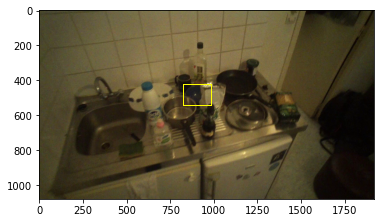

In [5]:
first_frame = get_frame_from_number(rdm_video_path, num_first_frame_with_coord[0])
plt.imshow(cv2.cvtColor(first_frame, cv2.COLOR_BGR2RGB))
box_first_frame_coords = num_first_frame_with_coord[1]
plot_box(plt, rect=box_first_frame_coords, linewidth=1)

### 2. Récupération de la frame suivante et génération de boites aléatoires

plot 50


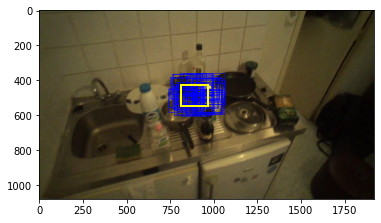

In [6]:
# On récupère la frame d'après
num_next_frame = num_first_frame_with_coord[0] + 1
next_frame = get_frame_from_number(rdm_video_path, num_next_frame)
rdm_boxes = generate_rdm_boxes_from_box(box_first_frame_coords,0.5,0.1,next_frame.shape[1],next_frame.shape[0],50)
all_true_boxes = get_all_true_box(list_bbox_path)

print('plot', len(rdm_boxes))
plt.imshow(cv2.cvtColor(next_frame, cv2.COLOR_BGR2RGB))
for box in rdm_boxes:
    plot_box(plt, rect=box, linewidth=0.5, color="blue")
plot_box(plt, rect=all_true_boxes[num_next_frame])

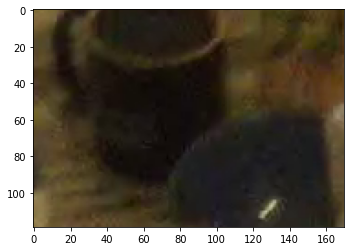

In [7]:
rdm_index = rd.randint(0,len(rdm_boxes)-1)
box = rdm_boxes[rdm_index]
img = next_frame[box[1]:box[1]+box[3],box[0]:box[0]+box[2]]
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# Tracking

In [8]:
import numpy as np
from tensorflow.keras import models
from copy import deepcopy
import cv2
import os, sys

import utils.helpers.constants as path
from utils.helpers.data import * 
from utils.helpers.plot import * 
from utils.helpers.video import * 

In [9]:
finalModel = models.load_model('models/vgg16_a__9.h5')

In [10]:
"""
Dans cette cellule les images apparaissent dans une autre fenêtre
il faut appuyer sur une touche du clavier pour passer à l'image suivante
"""
__batch_size__ = 32
class_labels, nb_labels = get_labels()
cv2.destroyAllWindows()

pred_boxes = []
num_first_frame, coords_first_box = get_num_first_frame_with_coord(list_bbox_path)
pred_boxes.append(coords_first_box)

true_boxes = get_all_true_box(list_bbox_path)

cap = cv2.VideoCapture(rdm_video_path)
if not cap.isOpened():
    print("ERROR: unable to read video:", rdm_video_path)
    sys.exit()

label = rdm_video_filename.split("Place")[0]
label_id = class_labels.index(label)

i = 0
sum_ious = 0
nb_frame_with_box = 0
while cap.isOpened():
    ret, frame = cap.read()
    if ret == False:
        break

    if i > num_first_frame:
        newBoxes = generate_rdm_boxes_from_box(
            pred_boxes[-1],
            0.4,
            0.1,
            frame.shape[1],
            frame.shape[0],
            nb_box=__batch_size__,
        )

        batch_imgs = []
        img_to_show = deepcopy(frame)
        for j, box in enumerate(newBoxes):
            img = frame[box[1] : box[1] + box[3], box[0] : box[0] + box[2]]
            draw_box_in_matrix(img_to_show, box, linewidth=1)
            cv2.imshow("Detection", cv2.resize(img_to_show, (960, 540)))
            cv2.waitKey(1)
            
            batch_imgs.append(cv2.resize(img, dsize=(227, 227)))

        batch_imgs = np.array(batch_imgs)
        model_prediction_batch = finalModel.predict(batch_imgs)

        proba = [[pr[i] for pr in model_prediction_batch] for i in range(nb_labels)]

        bestBox = newBoxes[np.argmax(proba[label_id])]
        if(true_boxes[i]) : 
            iou = compute_IOU(bestBox, true_boxes[i])
            print(f"IOU : {iou}")
            sum_ious += iou 
            nb_frame_with_box += 1
            draw_box_in_matrix(img_to_show, true_boxes[i], color=(0,255,0))
        draw_box_in_matrix(img_to_show, bestBox, color=(0,0,255))
        cv2.imshow("Detection", cv2.resize(img_to_show, (960, 540)),)
        # print("\r",f"Frame: {i}", max(proba[label_id]), min(proba[label_id]), end="")
        key =  cv2.waitKey(20)
        while key == -1:
             key = cv2.waitKey(10)

        pred_boxes.append(bestBox)

    i += 1



print(f"Mean IOU = {sum_ious/nb_frame_with_box}")


IOU : 0.3655929829733913
IOU : 0.5756831683168316
IOU : 0.4093156574704407


KeyboardInterrupt: 

In [14]:
cv2.destroyAllWindows()

-------------------